# Spike Detection Analysis


## Import Libraries


In [135]:
import matplotlib.pyplot as plt
from glob import glob
import numpy as np
import scipy.signal
import IPython.display as ipd
import matplotlib.colors as mcolors
from scipy.io import wavfile
from scipy.signal import lfilter, butter
from collections import deque
import sys

## Function Definitions


In [110]:
def identify_potential_initial_spikes(amplitude_array, return_local_maximum=True):
    """This function searches for peak amplitudes that may be initial
    neural spiking activity. This function is extended to filter the
    local maximum or minimum spiking activity. This is used to identify
    second or third spikes as well.

    Args:
        amplitude_array (numpy.ndarray): This contains an array of
                                         amplitudes of neural signal.
        return_local_maximum (bool, optional): This defines the logic of
                                               the returned values. If
                                               True, the values will be
                                               the local maximums of the
                                               amplitude array. When
                                               False,the returned list
                                               will be local minimums.

    Returns:
        list: This is a list of boolean values that indicate whether a
        point is a local maximum with respect to the next and previous
        amplitudes. If return_local_maximum is set to False, then the
        returned list contains information of local minimums instead.
    """
    if len(amplitude_array) < 3:
        if len(amplitude_array) == 0:
            return ValueError("Length of amplitude array must be greater than 0")
        elif len(amplitude_array) == 1:
            return [True]
        else:
            if return_local_maximum:
                if amplitude_array[0] < amplitude_array[1]:
                    return [False, True]
                else:
                    return [True, False]
            else:
                if amplitude_array[0] < amplitude_array[1]:
                    return [True, False]
                else:
                    return [False, True]
    else:
        if return_local_maximum:
            local_maximum_list = []
            for idx, val in enumerate(amplitude_array[0:-1]):
                if idx == 0:
                    if amplitude_array[idx + 1] < val:
                        local_maximum_list.append(True)
                    else:
                        local_maximum_list.append(False)
                    continue
                if (amplitude_array[idx - 1] < val) and (
                    val > amplitude_array[idx + 1]
                ):
                    local_maximum_list.append(True)
                else:
                    local_maximum_list.append(False)
            if amplitude_array[-1] > amplitude_array[-2]:
                local_maximum_list.append(True)
            else:
                local_maximum_list.append(False)
            return local_maximum_list
        else:
            local_minimum_list = []
            for idx, val in enumerate(amplitude_array[0:-1]):
                if idx == 0:
                    if amplitude_array[idx + 1] > val:
                        local_minimum_list.append(True)
                    else:
                        local_minimum_list.append(False)
                    continue
                if (amplitude_array[idx - 1] > val) and (
                    val < amplitude_array[idx + 1]
                ):
                    local_minimum_list.append(True)
                else:
                    local_minimum_list.append(False)
            if amplitude_array[-1] < amplitude_array[-2]:
                local_minimum_list.append(True)
            else:
                local_minimum_list.append(False)
            return local_minimum_list

In [111]:
WINDOW_SIZE = 10


def estimate_noise_floor(amplitude_array, window_size=WINDOW_SIZE):
    """This function will estimate the noise floor. The amplitude array
    must be at least of length of the window size or a single value.

    Args:
        amplitude_array (numpy.ndarray): Array of amplitudes with which
                                         to derive the noise floor.

        window_size (int, optional): This is the width of the window
                                     used to calculate a rolling median
                                     average.

    Return:
        noise_floor_estimate (np.ndarray): This is the estimate of the
                                           noise floor.
    """
    if len(amplitude_array) == 0:
        raise ValueError("Length of amplitude array must be greater than 0")
    elif len(amplitude_array) == 1:
        noise_floor_estimate = np.array(np.sqrt(np.abs(amplitude_array) ** 2))
        return noise_floor_estimate
    else:
        if len(amplitude_array) < window_size:
            window_size = len(amplitude_array)
        # power_of_filtered_data = np.abs(amplitude_array) * 2
        power_of_filtered_data = np.abs(amplitude_array) ** 2

        rolling_median_array = []
        for index in range(0, len(power_of_filtered_data), 1):
            current_median = np.median(
                power_of_filtered_data[index : index + window_size]
            )
            rolling_median_array.append(current_median)

        rolling_median_array = np.array(rolling_median_array)

        noise_floor_estimate = np.sqrt(rolling_median_array)

        return noise_floor_estimate

In [112]:
def detect_neural_spikes(t, neural_data):
    """This function detects spikes in real-time.
    It returns an array of spikes at specific times and amplitudes with
    zeroed out noise.

    Args:
        t (array): This is the array of values that indicate the time of
                   each point in the neural_data array.
        neural_data (array): This is the array of amplitudes for each
                             point of time of the neural data.
        sample_rate (int, optional): This is the frequency at which the
                                     data was sampled.

    Returns:
        (list): This is the array inclusive of amplitudes of spikes at
                each specific point in the initial time array. Non-spike
                points have been replaced with amplitudes of zero value.
    """
    noise_floor_window = 5
    initial_first_point_of_spike_detected = False
    second_point_of_spike_detected = False
    third_point_of_spike_detected = False
    spike_train_time_index_list = []

    for current_time_index, time in enumerate(t):
        # Estimate the noise floor
        if current_time_index < noise_floor_window:
            current_noise_floor_estimate_list = estimate_noise_floor(
                [neural_data[current_time_index]]
            )
        else:
            current_noise_floor_estimate_list = estimate_noise_floor(
                neural_data[
                    current_time_index - noise_floor_window : current_time_index
                ],
                window_size=noise_floor_window,
            )

        current_noise_floor_estimate = current_noise_floor_estimate_list[0]
        current_noise_floor_estimate_inverse = -(current_noise_floor_estimate)

        # Detect Initial First Point
        if initial_first_point_of_spike_detected == False:
            if current_time_index == 0:
                local_maximum_list_of_current_time_index = (
                    identify_potential_initial_spikes(
                        neural_data[current_time_index : current_time_index + 1]
                    )
                )
                is_current_time_index_local_maximum = (
                    local_maximum_list_of_current_time_index[0]
                )
            else:
                local_maximum_list_of_current_time_index = (
                    identify_potential_initial_spikes(
                        neural_data[current_time_index - 1 : current_time_index + 2]
                    )
                )
                is_current_time_index_local_maximum = (
                    local_maximum_list_of_current_time_index[1]
                )

            if is_current_time_index_local_maximum == True:
                # First Point Potentially Identified
                initial_first_point_of_spike_detected = True
                spike_time_index_first_point = current_time_index
        elif (
            second_point_of_spike_detected == False
            and initial_first_point_of_spike_detected == True
        ):
            # Detect Second Point
            local_minimum_list_of_current_time_index = (
                identify_potential_initial_spikes(
                    neural_data[current_time_index - 1 : current_time_index + 2],
                    return_local_maximum=False,
                )
            )
            is_current_time_index_local_minimum = (
                local_minimum_list_of_current_time_index[1]
            )
            if is_current_time_index_local_minimum == True:
                if (
                    neural_data[current_time_index]
                    < current_noise_floor_estimate_inverse
                ):
                    # Second Point Found
                    spike_time_index_list_first_to_second_points = np.arange(
                        start=spike_time_index_first_point,
                        stop=current_time_index,
                        step=1,
                    )
                    spike_time_index_second_point = current_time_index
                    second_point_of_spike_detected = True
                else:
                    initial_first_point_of_spike_detected = False
        elif (
            initial_first_point_of_spike_detected == True
            and second_point_of_spike_detected == True
            and third_point_of_spike_detected == False
        ):
            # Detect Third Point
            local_maximum_list_of_current_time_index = (
                identify_potential_initial_spikes(
                    neural_data[current_time_index - 1 : current_time_index + 2]
                )
            )
            is_current_time_index_local_maximum = (
                local_maximum_list_of_current_time_index[1]
            )
            if is_current_time_index_local_maximum == True:
                if neural_data[current_time_index] > current_noise_floor_estimate:
                    # Third Point Found
                    spike_time_index_list_second_to_third_points = np.arange(
                        spike_time_index_second_point, current_time_index + 1, step=1
                    )
                    third_point_of_spike_detected = True
                    time_index_of_most_recent_third_spike = current_time_index
                else:
                    initial_first_point_of_spike_detected = True
                    second_point_of_spike_detected = False
                    spike_time_index_first_point = current_time_index
        elif (
            initial_first_point_of_spike_detected == True
            and second_point_of_spike_detected == True
            and third_point_of_spike_detected == True
        ):
            # Detect Fourth Point
            if neural_data[current_time_index] < 0:
                time_index_of_most_recent_fourth_spike_point = current_time_index
                spike_time_index_list_third_to_fourth_points = np.arange(
                    time_index_of_most_recent_third_spike,
                    time_index_of_most_recent_fourth_spike_point + 1,
                    step=1,
                )
                spike_time_index_list = np.concatenate(
                    [
                        spike_time_index_list_first_to_second_points,
                        spike_time_index_list_second_to_third_points,
                        spike_time_index_list_third_to_fourth_points,
                    ]
                )
                spike_train_time_index_list.append(spike_time_index_list)

                initial_first_point_of_spike_detected = False
                second_point_of_spike_detected = False
                third_point_of_spike_detected = False
        else:
            raise ValueError("Error in Spike Detection State")

    return spike_train_time_index_list

In [113]:
def create_encoded_data(
    spike_train_time_index_list,
    neural_data,
    time_array_of_neural_data,
    sample_rate,
    number_of_samples,
):
    """This function creates an encoded version of the initial data.

    Args:
        spike_train_time_index_list (list): This is the list of array of
                                            floats that indicate indices
                                            of amplitudes.
        neural_data (array): These are the amplitudes of all values in
                             the dataset.
        time_array_of_neural_data (array): These are the points of time
                                           of the dataset.
        sample_rate (int): This is the sample rate of the data. The
                              samples are equidistant depending upon the
                              sampling frequency as calculated from the
                              inverse of the sample rate.
        number_of_samples (int): This is the total number of samples in
                                 the dataset.

    Returns:
        (list): This is the encoded data. This encoded data has the
                sample rate, the number of samples, the initial starting
                time of the first amplitude, and the information of the
                amplitudes of the detected eeg spikes. This pattern of
                the initial starting time of the first amplitude,
                represented as a float, followed by the array of
                amplitude values at each sample is repeated for each
                detected spike. It is implied that the samples are
                equidistant depending upon thesampling frequency as
                calculated from the inverse of thesample rate, that the
                length oftime of the entire datais inferred from the
                number of samplesdivided by thesample rate, and all
                amplitudes at samples notexplicitlydefined are to be
                considered noise and are therefore setto zero to
                reduce size while retaining information.
    """
    encoded_data = []
    encoded_data.append(sample_rate)
    encoded_data.append(number_of_samples)
    for spike_train_index in range(0, len(spike_train_time_index_list)):
        encoded_data.append(
            time_array_of_neural_data[spike_train_time_index_list[spike_train_index][0]]
        )
        encoded_data.append(neural_data[spike_train_time_index_list[spike_train_index]])
        encoded_data = deque(encoded_data)
    return encoded_data

## Load Data


In [114]:
data_dir = "../data/"
data_file_list = glob(data_dir + "*.wav")
data_file_list[0]

'../data/102b47d9-371e-412a-8995-0dc6115ab2bb.wav'

In [115]:
ipd.Audio(data_file_list[0])

In [116]:
sample_rate, raw_neural_data = wavfile.read(data_file_list[0])
time_array_length = len(raw_neural_data) / sample_rate
time_array = np.arange(start=0, stop=time_array_length, step=(1 / sample_rate))

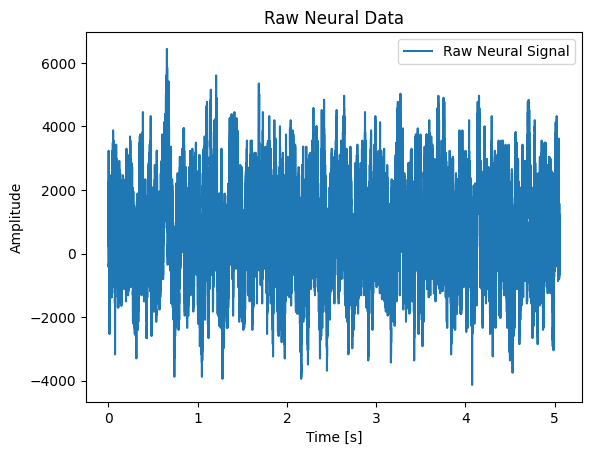

In [117]:
plt.plot(time_array, raw_neural_data)
plt.title("Raw Neural Data")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.legend(["Raw Neural Signal"])
plt.show()

## Preprocess the Signal


### Detrend & Normalize the Signal


In [118]:
# Detrend
detrended_neural_data = scipy.signal.detrend(raw_neural_data)

# Normalize
preprocessed_data = detrended_neural_data / detrended_neural_data.max()

# preprocessed_data = detrended_neural_data

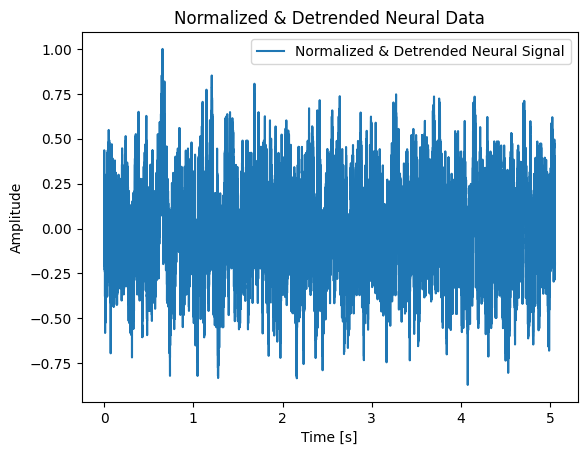

In [119]:
plt.plot(time_array, preprocessed_data)
plt.title("Normalized & Detrended Neural Data")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.legend(["Normalized & Detrended Neural Signal"])
plt.show()

### Band-Pass Filter


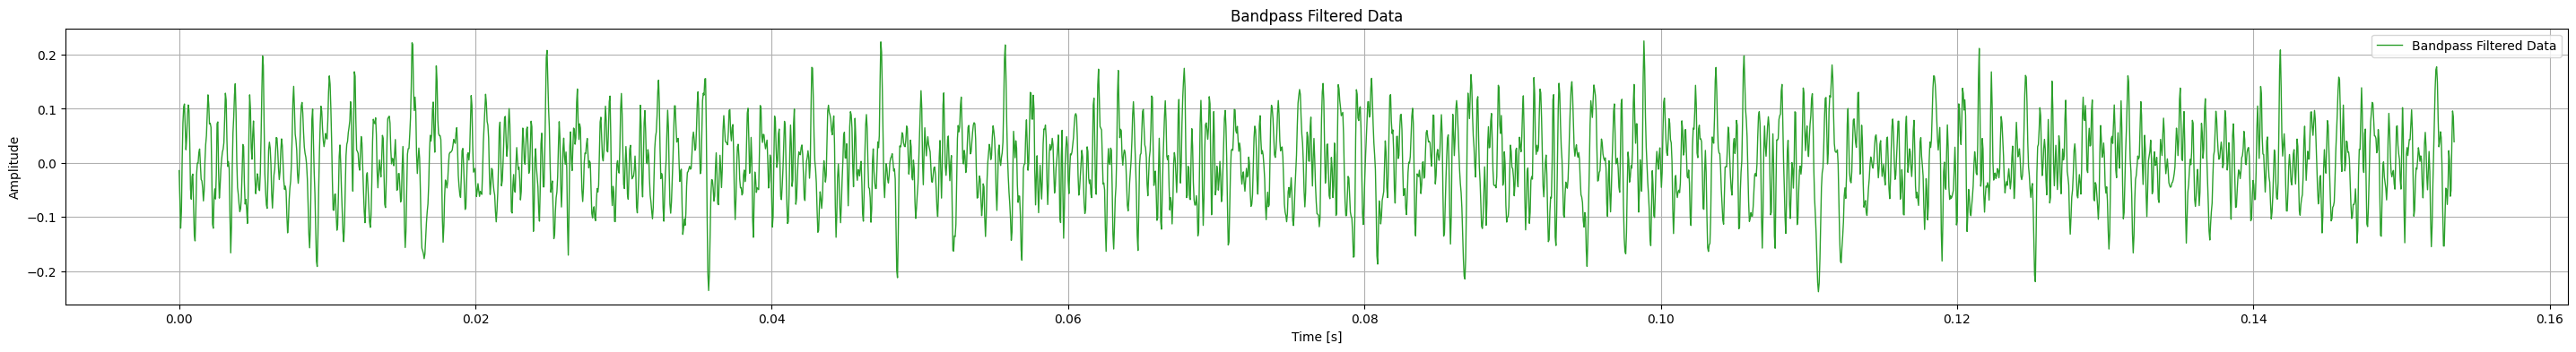

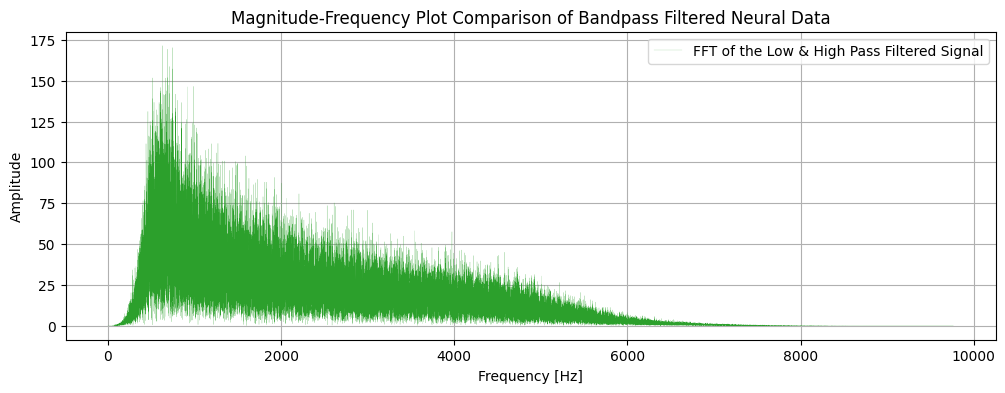

In [120]:
nyq = sample_rate // 2
low_cutoff_freq = 500
high_cutoff_freq = 5000
low = low_cutoff_freq / nyq
high = high_cutoff_freq / nyq
order = 4
b, a = butter(order, [low, high], btype="band")

filtered_data_bandpass = lfilter(b, a, preprocessed_data)

filtered_data_bandpass_fft = np.fft.fft(filtered_data_bandpass)
freq_bins_filtered_data_bandpass_fft = np.arange(
    0, sample_rate / 2, step=(sample_rate / len(filtered_data_bandpass_fft))
)

# Time Domain Plot
plt.figure(figsize=(36, 4))
plt.plot(
    time_array[0:3000],
    filtered_data_bandpass[0:3000],
    color=list(mcolors.TABLEAU_COLORS.keys())[2],
    linewidth=1,
    label="Bandpass Filtered Data",
)
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.title("Bandpass Filtered Data")
plt.legend()
plt.grid(True)
plt.show()

# FFT Plot
plt.figure(figsize=(12, 4))
plt.plot(
    freq_bins_filtered_data_bandpass_fft[
        0 : len(freq_bins_filtered_data_bandpass_fft) - 1
    ],
    np.abs(filtered_data_bandpass_fft[0 : len(filtered_data_bandpass_fft) // 2]),
    color=list(mcolors.TABLEAU_COLORS.keys())[2],
    label="FFT of the Low & High Pass Filtered Signal",
    linewidth=0.1,
)

plt.xlabel("Frequency [Hz]")
plt.ylabel("Amplitude")
plt.title("Magnitude-Frequency Plot Comparison of Bandpass Filtered Neural Data")
plt.legend()
plt.grid(True)
plt.show()

### Identifying Potential First Spike Points


In [121]:
local_maximum_list = identify_potential_initial_spikes(filtered_data_bandpass)

### Identifying Noise Floor Estimate


In [122]:
noise_floor_estimate = estimate_noise_floor(filtered_data_bandpass, window_size=5)
noise_floor_estimate_inverse = -(noise_floor_estimate)

### Plotting Results


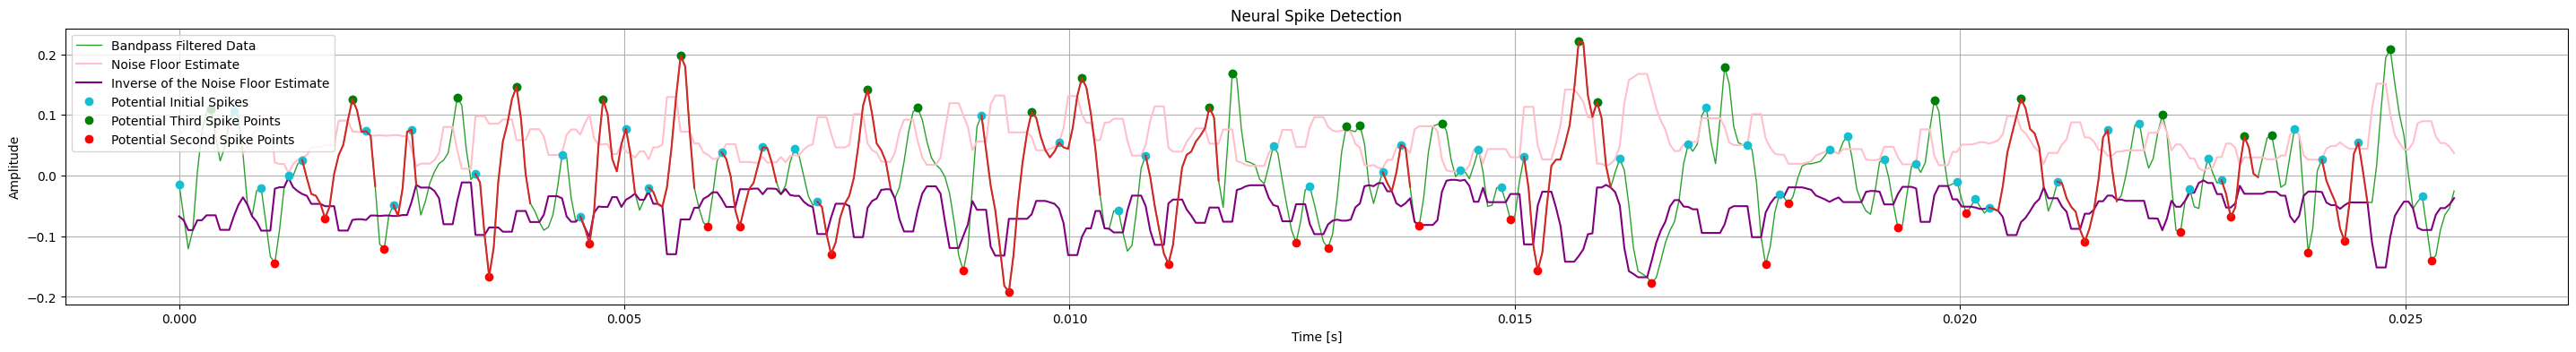

In [123]:
# Time Domain Plot
# WINDOW_SIZE = len(time_array)
PLOT_WINDOW_SIZE = 500

# Subsets
time_array_subset = time_array[0:PLOT_WINDOW_SIZE]
filtered_data_bandpass_subset = filtered_data_bandpass[0:PLOT_WINDOW_SIZE]
noise_floor_estimate_subset = noise_floor_estimate[0:PLOT_WINDOW_SIZE]
noise_floor_estimate_inverse_subset = noise_floor_estimate_inverse[0:PLOT_WINDOW_SIZE]

# Calculating Spikes
# Third Points
time_array_subset_above_noise_floor_estimate = time_array_subset[
    filtered_data_bandpass_subset > noise_floor_estimate_subset
]
filtered_data_bandpass_subset_above_noise_floor_estimate = (
    filtered_data_bandpass_subset[
        filtered_data_bandpass_subset > noise_floor_estimate_subset
    ]
)

filtered_data_bandpass_subset_above_noise_floor_estimate_local_maximum_list = (
    identify_potential_initial_spikes(
        filtered_data_bandpass_subset_above_noise_floor_estimate
    )
)

third_points = filtered_data_bandpass_subset_above_noise_floor_estimate[
    filtered_data_bandpass_subset_above_noise_floor_estimate_local_maximum_list
]
time_third_points = time_array_subset_above_noise_floor_estimate[
    filtered_data_bandpass_subset_above_noise_floor_estimate_local_maximum_list
]

# Second Points
time_array_subset_below_noise_floor_estimate_inverse = time_array_subset[
    filtered_data_bandpass_subset < noise_floor_estimate_inverse_subset
]

filtered_data_bandpass_subset_below_noise_floor_estimate_inverse = (
    filtered_data_bandpass_subset[
        filtered_data_bandpass_subset < noise_floor_estimate_inverse_subset
    ]
)
filtered_data_bandpass_subset_below_noise_floor_estimate_inverse_local_minimum_list = (
    identify_potential_initial_spikes(
        filtered_data_bandpass_subset_below_noise_floor_estimate_inverse,
        return_local_maximum=False,
    )
)

second_points = filtered_data_bandpass_subset_below_noise_floor_estimate_inverse[
    filtered_data_bandpass_subset_below_noise_floor_estimate_inverse_local_minimum_list
]
t_second_points = time_array_subset_below_noise_floor_estimate_inverse[
    filtered_data_bandpass_subset_below_noise_floor_estimate_inverse_local_minimum_list
]

spike_train_time_index_list = detect_neural_spikes(time_array, filtered_data_bandpass)

plt.figure(figsize=(36, 4))
# Time Domain Signal Values
plt.plot(
    time_array[0:PLOT_WINDOW_SIZE],
    filtered_data_bandpass[0:PLOT_WINDOW_SIZE],
    color=list(mcolors.TABLEAU_COLORS.keys())[2],
    linewidth=1,
    label="Bandpass Filtered Data",
)
plt.plot(
    time_array[0:PLOT_WINDOW_SIZE],
    noise_floor_estimate[0:PLOT_WINDOW_SIZE],
    label="Noise Floor Estimate",
    color="pink",
)
plt.plot(
    time_array[0:PLOT_WINDOW_SIZE],
    noise_floor_estimate_inverse[0:PLOT_WINDOW_SIZE],
    label="Inverse of the Noise Floor Estimate",
    color="purple",
)

# Thresholded Points
plt.plot(
    time_array_subset[local_maximum_list[0:PLOT_WINDOW_SIZE]],
    filtered_data_bandpass_subset[local_maximum_list[0:PLOT_WINDOW_SIZE]],
    "o",
    color=list(mcolors.TABLEAU_COLORS.keys())[9],
    label="Potential Initial Spikes",
)

plt.plot(
    time_third_points,
    third_points,
    "o",
    color="green",
    label="Potential Third Spike Points",
)

plt.plot(
    t_second_points,
    second_points,
    "o",
    color="red",
    label="Potential Second Spike Points",
)

# Detected Spikes
MAX_SPIKES_TO_PLOT = 15
for SPIKE_NUMBER in range(0, MAX_SPIKES_TO_PLOT):
    plt.plot(
        time_array[spike_train_time_index_list[SPIKE_NUMBER]],
        filtered_data_bandpass[spike_train_time_index_list[SPIKE_NUMBER]],
        "-",
        color=list(mcolors.TABLEAU_COLORS.keys())[3],
    )

plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.title("Neural Spike Detection")
plt.legend()
plt.grid(True)
plt.show()

In [124]:
encoded_data = create_encoded_data(
    spike_train_time_index_list,
    filtered_data_bandpass,
    time_array,
    sample_rate,
    len(filtered_data_bandpass),
)

In [125]:
encoded_data

deque([19531,
       98699,
       0.0013824176949464952,
       array([ 0.02565316, -0.00382868, -0.03037931, -0.03326891, -0.04663773,
              -0.07026952, -0.05115989,  0.00272574,  0.03392351,  0.05045518,
               0.0906306 ,  0.12571857,  0.12571857,  0.10823635,  0.07195043,
               0.07316749,  0.06573829, -0.01734453]),
       0.0024064308023142695,
       array([-0.04796864, -0.06663111, -0.02194891,  0.07236652,  0.07572774,
               0.07572774, -0.01520237]),
       0.0033280425989452665,
       array([ 0.00245232, -0.01128921, -0.09791368, -0.1662998 , -0.11881608,
              -0.01012176,  0.05593676,  0.08550263,  0.12612742,  0.14633798,
               0.14633798,  0.09252984,  0.00269916, -0.04547597]),
       0.004505657672418207,
       array([-0.06743883, -0.08608759, -0.11184925, -0.06148809,  0.05103962,
               0.1257583 ,  0.1257583 ,  0.10067466,  0.02752438,  0.00689678,
               0.05162372,  0.07746611,  0.03549511, -0.

In [145]:
# Percent Reduction in file size
print(
    "The original file size has been reduced by %0.2f%%. "
    % ((1 - sys.getsizeof(encoded_data) / sys.getsizeof(raw_neural_data)) * 100)
)

The original file size has been reduced by 71.28%. 


# Decoding the data


In [131]:
var = encoded_data.popleft()

In [136]:
sample_rate = encoded_data.popleft()
number_of_samples = encoded_data.popleft()

In [137]:
sample_rate

19531

In [138]:
number_of_samples

98699

In [139]:
encoded_data

deque([0.0013824176949464952,
       array([ 0.02565316, -0.00382868, -0.03037931, -0.03326891, -0.04663773,
              -0.07026952, -0.05115989,  0.00272574,  0.03392351,  0.05045518,
               0.0906306 ,  0.12571857,  0.12571857,  0.10823635,  0.07195043,
               0.07316749,  0.06573829, -0.01734453]),
       0.0024064308023142695,
       array([-0.04796864, -0.06663111, -0.02194891,  0.07236652,  0.07572774,
               0.07572774, -0.01520237]),
       0.0033280425989452665,
       array([ 0.00245232, -0.01128921, -0.09791368, -0.1662998 , -0.11881608,
              -0.01012176,  0.05593676,  0.08550263,  0.12612742,  0.14633798,
               0.14633798,  0.09252984,  0.00269916, -0.04547597]),
       0.004505657672418207,
       array([-0.06743883, -0.08608759, -0.11184925, -0.06148809,  0.05103962,
               0.1257583 ,  0.1257583 ,  0.10067466,  0.02752438,  0.00689678,
               0.05162372,  0.07746611,  0.03549511, -0.02959767]),
       0.0052736